# Oil Boiler Emissions - Impact on Air Quality

### In this study, I intend to predict GHG emssions  using Random Forest Regression and establish a relationship between oil boilers and GHG emissions

### Importing required packages

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import geopandas as gpd
import os
import scipy
from scipy.interpolate import griddata as gd
import statsmodels.formula.api as smf
import laspy
from fiona.crs import from_epsg
from geopandas.tools import sjoin
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics, cross_validation
%pylab inline

Populating the interactive namespace from numpy and matplotlib


I used all the downloaded files. The files are added to my GitHub repo along with this notebook.

### Reading Oil data.

In [3]:
path = os.getenv('PUIDATA')

In [4]:
oil_data = pd.read_csv(path+'/Oil_Boilers_-_Detailed_Fuel_Consumption_and_Building_Data.csv')
#oil_data = pd.read_csv('Oil_Boilers_-_Detailed_Fuel_Consumption_and_Building_Data.csv')

In [5]:
oil_data = oil_data.drop([ 'Facility Address', 'Borough',
       'Community Board',
       'Council District','NTA',
       'Natural Gas Utility (Con Edison or National Grid', 'DEP Boiler Application #',
       'Deadline for phasing out #6 oil (i.e. data of next DEP permit renewal after July 1 2012)',
       'Boiler Model', 'Number of identical boilers','Boiler Installation Date',
       'Estimated retirement date of boiler (assuming 35 year average useful life)',
       'Is boiler dual fuel capable?',
       'Total Estimated Cosumption - Low Estimate (Gallons) ',
       'Total Estimated Cosumption - High Estimate (MMBTUs) ',
       'Total Estimated Cosumption - Low Estimate  (MMBTUs) ',
       'Deadline for complying with Audit and Retrocommissioning Law',
         'City Council District','Number of total units',
       'Total area of buildings on lot',
       'Number of buildings on property (tax lot)', 'Number of floors',
       'Year constructed', 'Condominium housing?', 'Cooperative housing?','Building Manager', 
                          'Owner', 'Owner Address'],axis=1)

In [6]:
oil_data.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,Total Estimated Cosumption - High Estimate (Gallons),Needs to comply with Greener Greater Buildings Laws?,Building Type,Number of residential units
0,1007910062,NaN,NaN,NaN,NaN,NaN,2.80,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,32016,NaN,Office Buildings,42
1,1012440072,NaN,NaN,NaN,NaN,NaN,14.00,26 to 30 years old,ICI DEG 175 P,#6,146000,Yes,Elevator Apartments,87
2,2025080024,NaN,NaN,NaN,NaN,NaN,2.80,Over 50 years,HEV-E-OIL AL4C,#4,30814,NaN,Elevator Apartments,30
3,2029900034,10460.0,40.835731,-73.886595,161.0,2010678.0,2.60,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,25309,NaN,Loft Buildings,26
4,2024720028,NaN,NaN,NaN,NaN,NaN,2.59,21 to 26 years old,ICI - MMG 30,#4,25000,NaN,Elevator Apartments,36


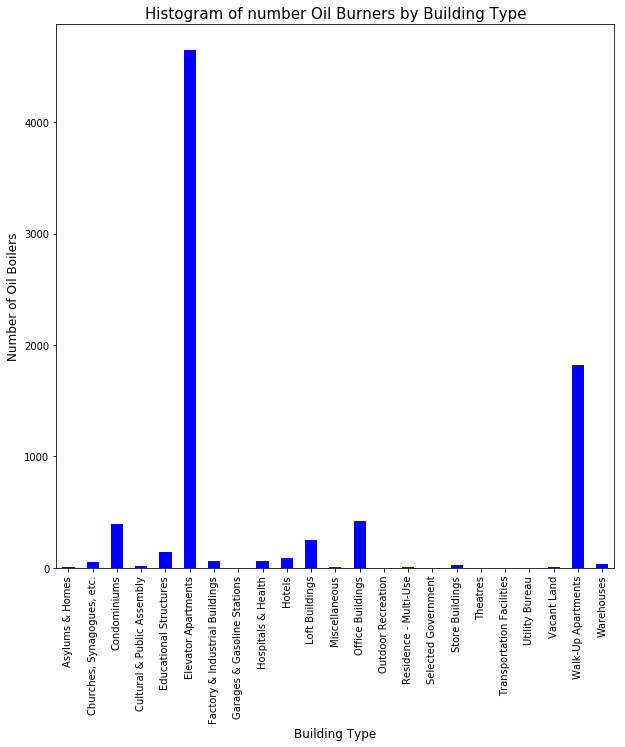

In [7]:
ax=pl.figure(figsize=(10,10))
ax1= ((oil_data['Total Estimated Cosumption - High Estimate (Gallons) '].groupby(oil_data['Building Type'])\
       .count().plot(kind="bar",color='blue')))
ax1.set_title('Histogram of number Oil Burners by Building Type', fontsize=15)
ax1.set_ylabel('Number of Oil Boilers', fontsize=12)
ax1.set_xlabel('Building Type', fontsize=12);

#### Fig1: This figure gives us the Count of Oil Burners by Building Type across the city

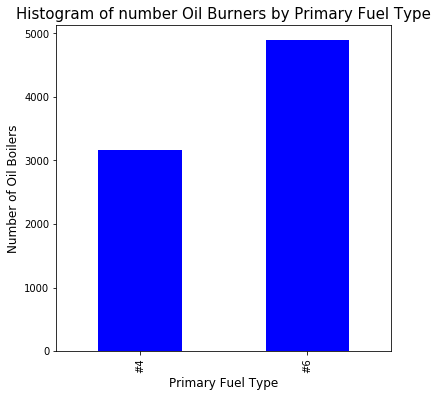

In [8]:
ax=pl.figure(figsize=(6,6))
ax1= ((oil_data['Total Estimated Cosumption - High Estimate (Gallons) '].groupby(oil_data['Primary Fuel']).\
       count().plot(kind="bar",color='blue')))
ax1.set_title('Histogram of number Oil Burners by Primary Fuel Type', fontsize=15)
ax1.set_ylabel('Number of Oil Boilers', fontsize=12)
ax1.set_xlabel('Primary Fuel Type', fontsize=12);


#### Fig 2: This figure gives us the count of oil boilers by the primary fuel type

## Reading Benchmarking Data

In [9]:
#bmark = pd.read_csv('nyc_benchmarking_disclosure_data_reported_in_2016.csv')
bmark = pd.read_csv(path+'/nyc_benchmarking_disclosure_data_reported_in_2016.csv')

In [10]:
bmark = bmark.drop(['Unnamed: 0', 'Record Number', 'Order',
        'Co-reported BBL Status',
       'BBLs Co-reported',
        'Property Name',
       'Parent Property Id', 'Parent Property Name', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'List of All Property Use Types at Property',
       'Largest Property Use Type',
       'Largest Property Use Type - Gross Floor Area (ft²)',
       '2nd Largest Property Use Type',
       '2nd Largest Property Use - Gross Floor Area (ft²)',
       '3rd Largest Property Use Type',
       '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Year Built',
       'Number of Buildings - Self-reported', 'Occupancy',
       'Metered Areas (Energy)', 'Metered Areas  (Water)', 'ENERGY STAR Score',
        'Weather Normalized Site EUI (kBtu/ft²)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Source EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
         'District Steam Use (kBtu)',
       'District Hot Water Use (kBtu)', 'District Chilled Water Use (kBtu)',
       'Natural Gas Use (kBtu)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Weather Normalized Site Electricity (kWh)',
       'DOF Property Floor Area (ft²)', 'Property GFA - Self-reported (ft²)',
       'Water Use (All Water Sources) (kgal)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Release Date', 'DEP Provided Water Use (kgal)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method'],axis=1)

In [11]:
bmark.head()

,"NYC Borough, Block and Lot (BBL)",Reported NYC Building Identification Numbers (BINs),Zip Code,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.003360e+09,1088884,10002.0,Multifamily Housing,73.7,Not Available,Not Available,Not Available,Not Available,Not Available,436.3,290.2,146.1
1,1.010618e+09,1026728,10019.0,Multifamily Housing,51.3,Not Available,Not Available,Not Available,Not Available,Not Available,201.4,76.4,125.0
2,1.014270e+09,1043974,10021.0,Multifamily Housing,44.9,Not Available,Not Available,Not Available,Not Available,Not Available,538.4,145.5,392.9
3,1.015180e+09,1048117,10128.0,Multifamily Housing,91.3,Not Available,Not Available,Not Available,Not Available,Not Available,699.3,304.6,394.7
4,1.003920e+09,1079685,10009.0,Residence Hall/Dormitory,NaN,Not Available,Not Available,Not Available,Not Available,Not Available,0.0,0.0,0.0


## Reading census data

In [12]:
mhi_data = pd.read_csv(path+'/ACS_16_5YR_S1901_with_ann.csv')
#mhi_data = pd.read_csv('Median_Income/ACS_16_5YR_S1901_with_ann.csv')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
mhi_data = mhi_data.drop([0])

In [14]:
mhi_data = mhi_data[['GEO.id','GEO.id2','GEO.display-label','HC01_EST_VC01']]

In [15]:
mhi_data.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01
1,1400000US36001000100,36001000100,"Census Tract 1, Albany County, New York",843
2,1400000US36001000200,36001000200,"Census Tract 2, Albany County, New York",2049
3,1400000US36001000300,36001000300,"Census Tract 3, Albany County, New York",2324
4,1400000US36001000401,36001000401,"Census Tract 4.01, Albany County, New York",1016
5,1400000US36001000403,36001000403,"Census Tract 4.03, Albany County, New York",2294


### Reading Zip-Tract relationship file

In [16]:
tract = pd.read_csv(path+'/ZIP_TRACT_122016.csv')
#tract = pd.read_csv('ZIP_TRACT_122016.csv')

In [17]:
census_data = pd.merge(mhi_data, tract, left_on=mhi_data['GEO.id2'], right_on=tract.TRACT)

In [18]:
census_data.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_EST_VC01,Unnamed: 0,ZIP,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,1400000US36091062700,36091062700,"Census Tract 627, Saratoga County, New York",2651,17562,12188,36091062700,0.554195,0.380952,0.398649,0.544356
1,1400000US36091062800,36091062800,"Census Tract 628, Saratoga County, New York",989,17561,12188,36091062800,0.201325,0.369048,0.533784,0.215931
2,1400000US36093020101,36093020101,"Census Tract 201.01, Schenectady County, New York",1130,17753,12308,36093020101,0.211167,0.063694,0.214765,0.205514
3,1400000US36093020101,36093020101,"Census Tract 201.01, Schenectady County, New York",1130,17762,12309,36093020101,0.024028,0.009042,0.012552,0.023220
4,1400000US36093020102,36093020102,"Census Tract 201.02, Schenectady County, New York",1020,17751,12308,36093020102,0.134621,0.057325,0.051454,0.126850


In [19]:
census_data.columns

Index(['GEO.id', 'GEO.id2', 'GEO.display-label', 'HC01_EST_VC01', 'Unnamed: 0',
       'ZIP', 'TRACT', 'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO', 'TOT_RATIO'],
      dtype='object')

In [20]:
census_data['HC01_EST_VC01'] = census_data['HC01_EST_VC01'].astype(float)

In [21]:
census_data = census_data.groupby(census_data.ZIP).mean()

In [22]:
del census_data['ZIP']
census_data.reset_index(inplace=True)

In [23]:
census_data.head()

,ZIP,HC01_EST_VC01,Unnamed: 0,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,501,1197.0,0.0,3.610316e+10,0.000000,1.000000,0.000000,1.000000
1,6390,1901.0,7472.0,3.610317e+10,1.000000,1.000000,0.000000,1.000000
2,10466,1315.5,12981.0,3.611900e+10,0.000743,0.000000,0.000574,0.000698
3,10470,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
4,10475,1738.0,13128.0,3.611901e+10,0.000000,0.001212,0.000000,0.000044


### Merging benchmarking and census data

In [24]:
bmark['Zip Code'] = bmark['Zip Code'].astype(float)
census_data.ZIP = census_data.ZIP.astype(float)

In [25]:
census_bmark = pd.merge(bmark, census_data, left_on=bmark['Zip Code'] , right_on=census_data.ZIP )

In [26]:
census_bmark.head()

,"NYC Borough, Block and Lot (BBL)",Reported NYC Building Identification Numbers (BINs),Zip Code,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),...,Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),ZIP,HC01_EST_VC01,Unnamed: 0,TRACT,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,2.033630e+09,2018704,10470.0,Multifamily Housing,72.2,Not Available,Not Available,Not Available,Not Available,Not Available,...,238.7,93.1,10470.0,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
1,2.033680e+09,2018858,10470.0,Multifamily Housing,58.3,Not Available,7069284.5,Not Available,Not Available,Not Available,...,544.5,117.6,10470.0,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
2,2.033800e+09,2019289,10470.0,Multifamily Housing,116.9,Not Available,3381000.1,Not Available,Not Available,Not Available,...,411.3,35.5,10470.0,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
3,2.033820e+09,2019330,10470.0,Multifamily Housing,93.3,Not Available,Not Available,4160416.1,Not Available,Not Available,...,317.8,41.5,10470.0,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328
4,2.033830e+09,2019336,10470.0,Multifamily Housing,98.9,Not Available,824411.9,Not Available,Not Available,Not Available,...,508.7,135.2,10470.0,1017.5,13073.0,3.611900e+10,0.003909,0.008523,0.005319,0.004328


In [27]:
census_bmark.columns

Index(['NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)', 'ZIP', 'HC01_EST_VC01',
       'Unnamed: 0', 'TRACT', 'RES_RATIO', 'BUS_RATIO', 'OTH_RATIO',
       'TOT_RATIO'],
      dtype='object')

In [28]:
census_bmark = census_bmark[census_bmark['Primary Property Type - Self Selected'] == 'Multifamily Housing']

### Data Cleaning

In [29]:
print ("Are there missing values? -->", census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().values.any())
print ("There are %i missing values out of %i properties (%.1f percent)" %(census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().sum(), 
                                                                        len(census_bmark), 
                                                                        census_bmark['Total GHG Emissions (Metric Tons CO2e)'].isnull().sum()
                                                                          /float(len(census_bmark))*100))

Are there missing values? --> True
There are 1 missing values out of 55 properties (1.8 percent)


In [30]:
# Drop nans
census_bmark = census_bmark.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'])
print ('Examples after dropping NaNs:', len(census_bmark))

Examples after dropping NaNs: 54


In [31]:
# Drop zero EUI values
census_bmark = census_bmark[census_bmark['Total GHG Emissions (Metric Tons CO2e)']>0]
print ('Examples after dropping zeros:', len(census_bmark))

Examples after dropping zeros: 54


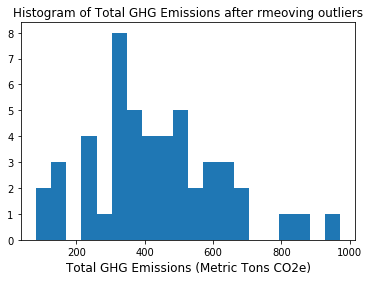

In [32]:
pl.hist(census_bmark['Total GHG Emissions (Metric Tons CO2e)']\
        [census_bmark['Total GHG Emissions (Metric Tons CO2e)']<1000], bins=20)
pl.xlabel('Total GHG Emissions (Metric Tons CO2e)',fontsize=12)
pl.title('Histogram of Total GHG Emissions after rmeoving outliers')
pl.show()

#### Fig 3: Distribution of GHG Emissions. From the figure we can see it follows Gaussian Distribution 

In [33]:
def clean(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_ghg<np.mean(df.log_ghg)+2*np.std(df.log_ghg))&(df.log_ghg>np.mean(df.log_ghg)-2*np.std(df.log_ghg))]
    return df

census_bmark['ghg'] = census_bmark['Total GHG Emissions (Metric Tons CO2e)']
census_bmark['log_ghg'] = np.log10(census_bmark.ghg)
census_bmark = clean(census_bmark)
print ('Examples after cleaning GHG:', len(census_bmark))

Examples after cleaning GHG: 51


In [34]:
census_bmark['Total GHG Emissions (Metric Tons CO2e)'].describe()

count      51.000000
mean      512.088235
std       340.449001
min       100.900000
25%       331.300000
50%       436.600000
75%       590.950000
max      1846.400000
Name: Total GHG Emissions (Metric Tons CO2e), dtype: float64

In [35]:
list(zip(['A', 'B', 'C'], census_bmark['Total GHG Emissions (Metric Tons CO2e)'].describe()[4:7].values))

[('A', 331.30000000000001),
 ('B', 436.60000000000002),
 ('C', 590.95000000000005)]

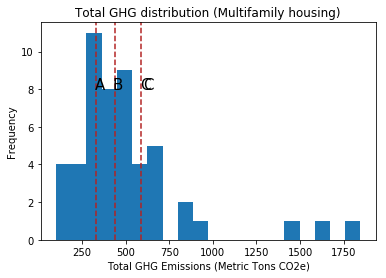

In [36]:
plt.hist(census_bmark['Total GHG Emissions (Metric Tons CO2e)'], bins=20)
for label, pos in zip(['A', 'B', 'C'], census_bmark['Total GHG Emissions (Metric Tons CO2e)'].describe()[4:7].values):
    plt.axvline(x=pos, color='firebrick', linestyle='--')
    plt.text(pos-10, 8, label, fontsize=15)
plt.text(pos+10,8, 'C', fontsize=15)
#plt.xlim(0,2500)
plt.title('Total GHG distribution (Multifamily housing)')
plt.xlabel('Total GHG Emissions (Metric Tons CO2e)')
plt.ylabel('Frequency')
plt.show()

#### Fig 4: This plot gives the higher and lower bounds of GHG emisisons for Multifamily Housing

In [37]:
census_bmark['log_mhi'] = np.log10(census_bmark['HC01_EST_VC01'])

In [38]:
lm1= smf.ols(formula= "log_ghg ~ log_mhi ",data=census_bmark).fit()

In [39]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_ghg   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     2.069
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.157
Time:                        19:17:40   Log-Likelihood:                0.34837
No. Observations:                  51   AIC:                             3.303
Df Residuals:                      49   BIC:                             7.167
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6431      1.387      0.464      0.645        -2.145     3.431
log_mhi        0.6461      0.449      1.438      0.157        -0.257     1.549
==============================================================================
Omnibus:                        2.311   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                1.417
Skew:                          -0.240   Prob(JB):                        0.492
Kurtosis:                       3.660   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Correlation between log GHG and log MHI')

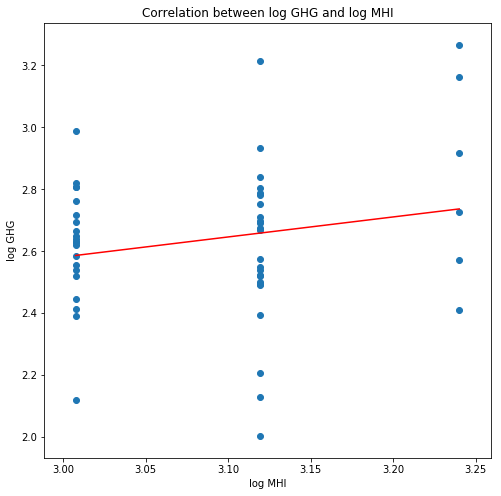

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(census_bmark['log_mhi'],census_bmark['log_ghg'])

plt.plot(census_bmark['log_mhi'],lm1.predict(),  c="r")
plt.xlabel('log MHI')
plt.ylabel('log GHG')
plt.title('Correlation between log GHG and log MHI')

#### Fig 5: This figure gives us the information about weak correlation between log of median household income and log of GHG emissions

## Merging oil and benchmarking data

In [41]:
merged_data = pd.merge(oil_data, bmark, left_on='BBL (Borough, Block and Lot)', right_on='NYC Borough, Block and Lot (BBL)',how='outer')

In [42]:
oil_bmark = merged_data
geo_data = merged_data

In [43]:
oil_bmark.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.007910e+09,NaN,NaN,NaN,NaN,NaN,2.8,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.012440e+09,NaN,NaN,NaN,NaN,NaN,14.0,26 to 30 years old,ICI DEG 175 P,#6,...,Multifamily Housing,76.1,Not Available,Not Available,14013371.4,Not Available,Not Available,1393.5,1082.0,311.5
2,2.025080e+09,NaN,NaN,NaN,NaN,NaN,2.8,Over 50 years,HEV-E-OIL AL4C,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.025080e+09,NaN,NaN,NaN,NaN,NaN,1.7,11 to 15 years old,ICI MMG 22,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.029900e+09,10460.0,40.835731,-73.886595,161.0,2010678.0,2.6,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
oil_bmark.columns

Index(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN', 'Boiler capacity (Gross BTU)',
       'Age range of boiler', 'Burner Model', 'Primary Fuel',
       'Total Estimated Cosumption - High Estimate (Gallons) ',
       'Needs to comply with Greener Greater Buildings Laws?', 'Building Type',
       'Number of residential units', 'NYC Borough, Block and Lot (BBL)',
       'Reported NYC Building Identification Numbers (BINs)', 'Zip Code',
       'Primary Property Type - Self Selected', 'Site EUI (kBtu/ft²)',
       'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)', 'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)'],
      dtype='object')

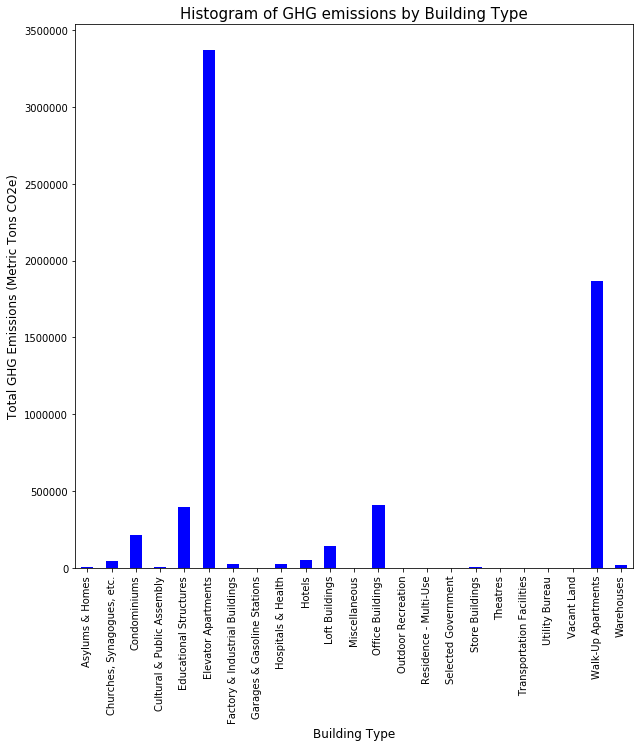

In [45]:
ax=pl.figure(figsize=(10,10))
ax1= ((oil_bmark['Total GHG Emissions (Metric Tons CO2e)'].groupby(oil_bmark['Building Type']).sum()\
       .plot(kind="bar",color='blue')))
ax1.set_title('Histogram of GHG emissions by Building Type', fontsize=15)
ax1.set_ylabel('Total GHG Emissions (Metric Tons CO2e)', fontsize=12)
ax1.set_xlabel('Building Type', fontsize=12);


#### Fig 6: This plot tells us anout the GHg emissions by Building Type

In [46]:
oil_bmark = oil_bmark.rename(columns={'Total Estimated Cosumption - High Estimate (Gallons) ':'Estimated_Consumption'
                                           , 'Total GHG Emissions (Metric Tons CO2e)':'Total_GHG'
                                           , 'Number of residential units':'Res_Units'})

In [47]:
len(oil_bmark)
#oil_bmark = oil_bmark.dropna()
#len(oil_bmark)

16933

In [48]:
oil_bmark = oil_bmark.drop(['BBL (Borough, Block and Lot)', 'Postcode', 'Latitude', 'Longitude',
       'Census Tract', 'BIN','Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)',
       'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)',
       'Diesel #2 Use (kBtu)','Burner Model','Primary Property Type - Self Selected',
    'NYC Borough, Block and Lot (BBL)','Reported NYC Building Identification Numbers (BINs)',
                           'Age range of boiler','Needs to comply with Greener Greater Buildings Laws?',
                          'Building Type','Direct GHG Emissions (Metric Tons CO2e)',
                           'Indirect GHG Emissions (Metric Tons CO2e)'], axis=1)

In [49]:
oil_bmark = oil_bmark.reset_index()
del oil_bmark['index']

In [50]:
oil_bmark = oil_bmark.dropna()

In [51]:
oil_bmark.head()

,Boiler capacity (Gross BTU),Primary Fuel,Estimated_Consumption,Res_Units,Zip Code,Site EUI (kBtu/ft²),Total_GHG
1,14.0,#6,146000.0,87.0,10024.0,76.1,1393.5
6,8.4,#6,60773.0,0.0,10018.0,72.1,872.2
7,4.2,#4,32000.0,68.0,11374.0,105.6,318.2
12,4.1,#4,41063.0,60.0,10027.0,99.6,456.5
14,10.4,#6,86000.0,168.0,11373.0,107.4,987.7


### Creating dummy dataframe to feed the random tree

In [52]:
dummy_df = oil_bmark[['Boiler capacity (Gross BTU)','Estimated_Consumption','Res_Units','Site EUI (kBtu/ft²)','Primary Fuel']]

In [53]:
dummy_df.head()

,Boiler capacity (Gross BTU),Estimated_Consumption,Res_Units,Site EUI (kBtu/ft²),Primary Fuel
1,14.0,146000.0,87.0,76.1,#6
6,8.4,60773.0,0.0,72.1,#6
7,4.2,32000.0,68.0,105.6,#4
12,4.1,41063.0,60.0,99.6,#4
14,10.4,86000.0,168.0,107.4,#6


In [54]:
dummy_df['Primary Fuel'] = pd.factorize(oil_bmark['Primary Fuel'].values)[0]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Diving training and test sample and running the random forest

In [55]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(dummy_df.values, 
                                                            oil_bmark['Total_GHG'], test_size=0.3, random_state=99)

In [56]:
clf =  ensemble.RandomForestRegressor(max_depth=5, random_state=99).fit(X_train, y_train)
clf.score(X_test, y_test)

0.82566518789873633

In [57]:
pred = clf.predict(dummy_df.values)

In [58]:
len(oil_bmark), len(pred)

(4739, 4739)

In [59]:
oil_bmark['Predicted_GHG'] = pred

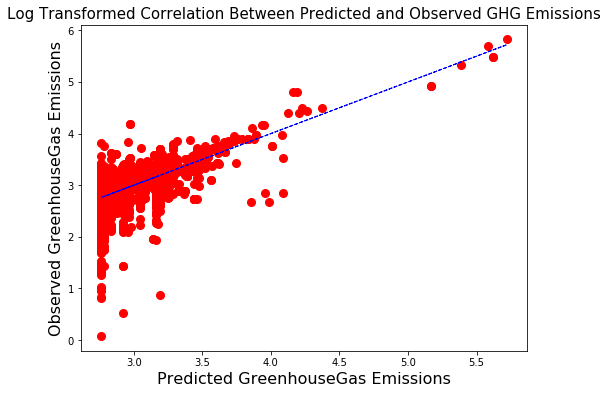

In [60]:
pl.figure(figsize = (8,6))
pl.plot(np.log10(pred),np.log10(oil_bmark['Total_GHG']),'or', markersize = 8) # Plot the observed value, linestyle = 'or', red dots
pl.plot(np.log10(pred),np.log10(pred),'--b', linewidth = 1)                 # Plot the predicted value, blue dashed line
#pl.xlim(0,400000)
#pl.ylim(0,400000)
# Plot setting
pl.xlabel('Predicted GreenhouseGas Emissions', fontsize = 16)
pl.ylabel('Observed GreenhouseGas Emissions', fontsize = 16)
pl.title('Log Transformed Correlation Between Predicted and Observed GHG Emissions', fontsize=15);

### Importing shapefiles to create choropleth

In [61]:
if not os.path.isdir(path + '/ZIP_CODES'):
    print('Download and unzip file...')
    os.system('wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')
    os.system('mv application%2Fzip ' + path)
    os.system('unzip ' + path + '/application%2Fzip -d ' + path + '/ZIP_CODES')

if os.path.isdir(path + '/ZIP_CODES'):
    for file in os.listdir(path + '/ZIP_CODES'):
        if file.endswith('.shp'):
            print('Shapefile in place..')
            shpfile = file

Shapefile in place..


In [62]:
shp = gpd.GeoDataFrame.from_file(path+'/ZIP_CODES/' + shpfile)
#shp = gpd.GeoDataFrame.from_file('ZIP_CODE_040114.shp')
shp.ZIPCODE = shp.ZIPCODE.astype(float)

In [63]:
oil_shp = pd.merge(oil_bmark, shp, left_on=oil_bmark['Zip Code'], right_on=shp.ZIPCODE)

In [64]:
oil_shp = gpd.GeoDataFrame(oil_shp)

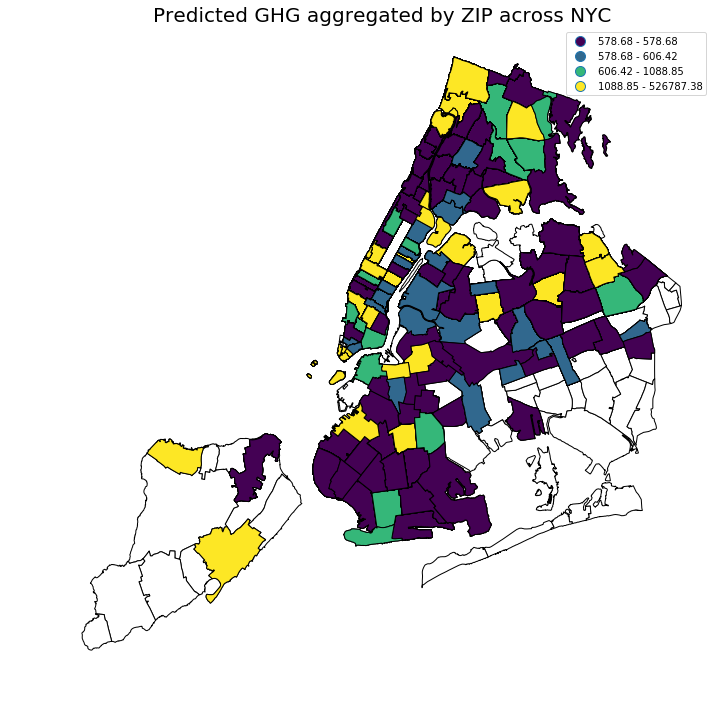

In [65]:
ax= shp.plot(color='w', edgecolor='k', figsize=(12,12))
oil_shp.plot(ax=ax, column='Predicted_GHG', edgecolor='k', cmap='viridis', figsize=(12,12), scheme='quantiles', legend=True)
ax.axis('off')
ax.set_title('Predicted GHG aggregated by ZIP across NYC', fontsize=20);

#### Fig 7: This figure gives us the information about the predicted GHG emissions in NYC. We can say that majority of Manhattan, Bronx and Staten Island have the highest GHG Emissions. Also, some parts are blank due to unavailability of data.

### Analzing the Air Quality data and representing individual pollutants on choropleths

In [66]:
shp.ZIPCODE = shp.ZIPCODE.astype(float)

In [67]:
geo_data.head()

,"BBL (Borough, Block and Lot)",Postcode,Latitude,Longitude,Census Tract,BIN,Boiler capacity (Gross BTU),Age range of boiler,Burner Model,Primary Fuel,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,1.007910e+09,NaN,NaN,NaN,NaN,NaN,2.8,31 to 35 years old,INDUSTRIAL COMBUSTION MEG-34S,#6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.012440e+09,NaN,NaN,NaN,NaN,NaN,14.0,26 to 30 years old,ICI DEG 175 P,#6,...,Multifamily Housing,76.1,Not Available,Not Available,14013371.4,Not Available,Not Available,1393.5,1082.0,311.5
2,2.025080e+09,NaN,NaN,NaN,NaN,NaN,2.8,Over 50 years,HEV-E-OIL AL4C,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.025080e+09,NaN,NaN,NaN,NaN,NaN,1.7,11 to 15 years old,ICI MMG 22,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.029900e+09,10460.0,40.835731,-73.886595,161.0,2010678.0,2.6,26 to 30 years old,HEV-E-OIL AMG 4 3/4,#4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
geo_shp = pd.merge(shp, geo_data, left_on=shp.ZIPCODE, right_on=geo_data['Zip Code'])

In [69]:
geo_shp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,Primary Property Type - Self Selected,Site EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e)
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,86.6,Not Available,Not Available,Not Available,Not Available,Not Available,1422.1,597.9,824.2
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,128.2,Not Available,Not Available,Not Available,Not Available,Not Available,1701.6,753.8,947.8
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,147.8,Not Available,Not Available,Not Available,Not Available,Not Available,592.2,168.0,424.3
3,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,136.9,Not Available,Not Available,Not Available,Not Available,Not Available,1901.1,859.5,1041.6
4,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,Hotel,85.6,Not Available,Not Available,Not Available,Not Available,Not Available,710.6,183.0,527.6


In [70]:
#boiler = pd.read_csv('BoilerAirData_2013.csv')
boiler = pd.read_csv(path+'/BoilerAirData_2013.csv') ## Air Quality data

In [71]:
#uhf = gpd.GeoDataFrame.from_file('Shapefile/UHF_42_DOHMH.shp') 
uhf = gpd.GeoDataFrame.from_file(path+'/Shapefiles/UHF_42_DOHMH.shp') ## UHF shapefile

In [72]:
boiler_PM = boiler[boiler.name=='Boiler Emissions- Total PM2.5 Emissions']

In [73]:
uhf_pm = pd.merge(uhf, boiler_PM, left_on='UHFCODE', right_on='geo_entity_id')

In [74]:
uhf_pm.head()

,UHFCODE,UHFNAME,BOROUGH,UHF,ALTCHPUHF,CHSUHF,SHAPE_Leng,SHAPE_Area,geometry,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,101.0,Kingsbridge - Riverdale,Bronx,101.0,Kingsbridge and Riverdale,101 Kingsbridge,57699.155405,1.332914e+08,"POLYGON ((1017992.893616721 269222.9643171281,...",130445,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,101,Kingsbridge - Riverdale,2013,2.0,NaN
1,102.0,Northeast Bronx,Bronx,102.0,the Northeast Bronx,102 Northeast Bronx,88219.321955,1.813708e+08,"POLYGON ((1025012.990336925 270794.2603199333,...",130446,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,102,Northeast Bronx,2013,0.3,NaN
2,103.0,Fordham - Bronx Park,Bronx,103.0,Fordham and Bronx Park,103 Fordham - Bronx Pk,59711.872129,1.407724e+08,"POLYGON ((1023994.479497686 261065.967421189, ...",130447,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,103,Fordham - Bronx Pk,2013,3.0,NaN
3,104.0,Pelham - Throgs Neck,Bronx,104.0,the Southeast Bronx,104 Pelham,250903.368668,3.865737e+08,(POLYGON ((1035076.590206906 252950.8257974088...,130448,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,104,Pelham - Throgs Neck,2013,0.5,NaN
4,105.0,Crotona - Tremont,Bronx,105.0,the Central Bronx,105 Crotona-Tremont,66676.088852,1.068978e+08,"POLYGON ((1007916.255088538 252530.7523161173,...",130449,641,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,105,Crotona -Tremont,2013,2.0,NaN


In [75]:
geo_shp = geo_shp.to_crs(epsg=2263)
uhf_pm = uhf_pm.to_crs(epsg=2263)

In [76]:
merged = sjoin(geo_shp, uhf_pm, how='left',op='intersects')   ## Creating spatial join to accommodate ZIP in UHF

In [77]:
merged.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN


In [78]:
merged = merged.dropna(subset=['data_valuemessage'])

In [79]:
merged.reset_index(inplace=True)

In [80]:
del merged['index']

In [92]:
merged.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN
3,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130480.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,0.1,NaN
4,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130479.0,641.0,Boiler Emissions- Total PM2.5 Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,0.1,NaN


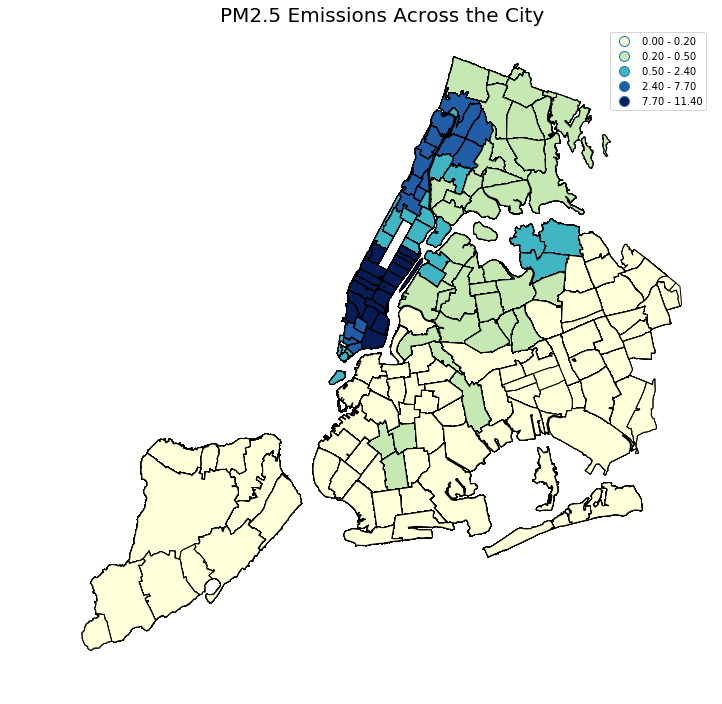

In [93]:
ax = merged.plot(column='data_valuemessage',edgecolor='k', figsize=(12,12), 
                 scheme='quantiles',cmap='YlGnBu', legend=True)
ax.axis('off')
pl.title('PM2.5 Emissions Across the City', fontsize=20);

#### Fig 8: Choropleth of PM2.5 emissions at Zip level across NYC. From the plot we can tell can Manhattan and parts of Bronx has highest ocntribution in PM2.5 emissions.

In [94]:
boiler_NO = boiler[boiler.name=='Boiler Emissions- Total NOx Emissions']

In [95]:
uhf_no = pd.merge(uhf, boiler_NO, left_on='UHFCODE', right_on='geo_entity_id')

In [96]:
uhf_no = uhf_no.to_crs(epsg=2263)

In [97]:
merged_no = sjoin(geo_shp, uhf_no, how='left',op='intersects')

In [98]:
merged_no.reset_index(inplace=True)

In [99]:
del merged_no['index']

In [100]:
merged_no = merged_no.dropna(subset=['data_valuemessage'])

In [101]:
merged_no.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130528.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,13.2,NaN
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN
3,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130528.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,13.2,NaN
4,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN


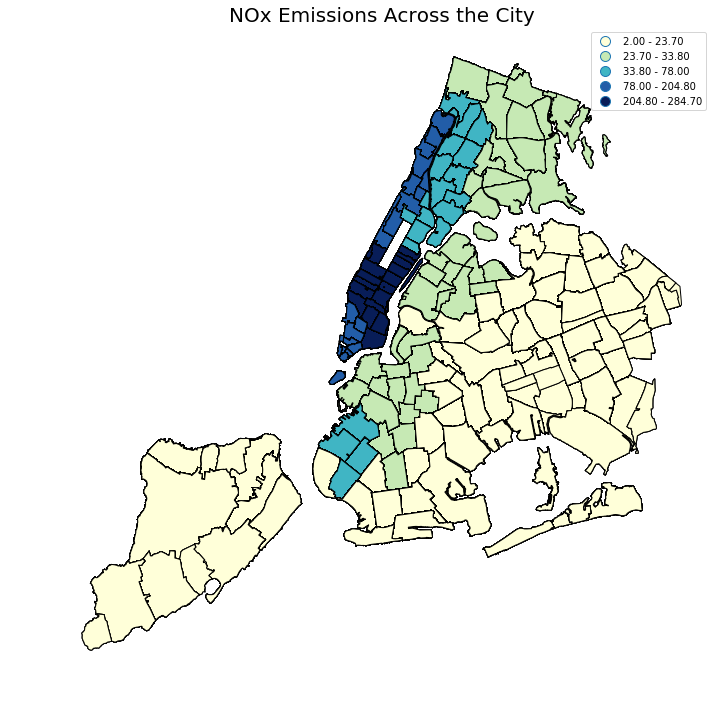

In [102]:
ax = merged_no.plot(column='data_valuemessage',edgecolor='k', figsize=(12,12), 
                 scheme='quantiles',cmap='YlGnBu', legend=True)
ax.axis('off')
pl.title('NOx Emissions Across the City', fontsize=20);

#### Fig 8: Choropleth of compunds of NO emissions at Zip level across NYC. From the plot we can tell that parts of Manhattan and parts of Bronx has highest ocntribution in NOx emissions.

In [103]:
boiler_so = boiler[boiler.name=='Boiler Emissions- Total SO2 Emissions']

In [104]:
uhf_so = pd.merge(uhf, boiler_so, left_on='UHFCODE', right_on='geo_entity_id')

In [105]:
uhf_so = uhf_no.to_crs(epsg=2263)
merged_so = sjoin(geo_shp, uhf_so, how='left',op='intersects')

In [106]:
merged_so.reset_index(inplace=True)
del merged_so['index']

In [107]:
merged_so = merged_so.dropna(subset=['data_valuemessage'])

In [108]:
merged_so.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,﻿indicator_data_id,indicator_id,name,Measure,geo_type_name,geo_entity_id,geo_entity_name,year_description,data_valuemessage,Unnamed: 9
0,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN
1,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130528.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,13.2,NaN
2,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN
3,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130528.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,408.0,Jamaica,2013.0,13.2,NaN
4,11436.0,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,130527.0,642.0,Boiler Emissions- Total NOx Emissions,Per km2,UHF42,407.0,Southwest Queens,2013.0,14.5,NaN


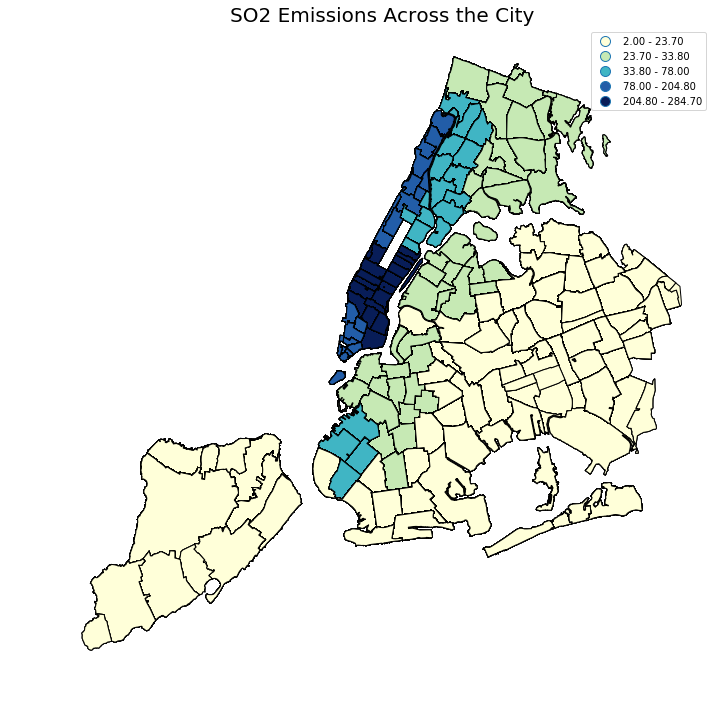

In [109]:
ax = merged_so.plot(column='data_valuemessage',edgecolor='k', figsize=(12,12), 
                 scheme='quantiles',cmap='YlGnBu', legend=True)
ax.axis('off')
pl.title('SO2 Emissions Across the City', fontsize=20);

#### Fig 8: Choropleth of SO2 emissions at Zip level across NYC. From the plot we can tell that most of Manhattan and parts of Bronx has highest ocntribution in NOx emissions.

### Running SQL Query to find out the number of oil boiler past their depreciation age

In [110]:
SQL_SOURCE = 'https://gauravbhardwaj.carto.com/api/v2/sql?q='
try:
    # Python 3 packages
    from urllib.parse import urlparse, urlencode
    from urllib.request import urlopen, Request
    from urllib.error import HTTPError
except ImportError:
    # Python 2 packages
    from urlparse import urlparse
    from urllib import urlencode
    from urllib2 import urlopen, Request, HTTPError
    
# works for both python 2 and 3
from io import StringIO
import ast
import pandas as pd

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    # added .encode('utf-8') to prevent errors in python 3
    data = urlencode({'format': format, 'q': query}).encode('utf-8')
    try:
        response = urlopen(source, data)
    # changed syntax to use 'as' keyword
    except HTTPError as e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return pd.read_csv(response)

In [111]:
test= '''
SELECT count(*) FROM oil_boilers where boiler_installation_date < 2000
'''
queryCartoDB(test)

,count,Unnamed: 1
0,6608,NaN


## Conclusion

The  random forest regression model I used gave me a good score or 0.87 which means  it can estimate the values of my dependent variable to a great extent. When I plotted  the observed and predicted values of greenhouse gases, I got a linear output  which means the predictions I made are correct and beneficial. In domain context,  I can say that the variables I chose, Boiler capacity estimated energy consumption,  residential units, building energy use intensity and primary fuel type give me  good predicted values of greenhouse gas emissions. With further addition of  data from any source, I can say with 95% confidence that my model will  predicted accurate values of greenhouse gas emissions. 
    
 
    
Since  we have further classified data of pollutants, I went ahead and used three of  the most common pollutants in the air i.e. Sulphur dioxide, compounds of nitrogen  oxide and PM2.5 and mapped them on the map of NYC as displayed in Fig 9, 10 and  11. From our analysis, we can say that Manhattan is the highest contributor of  greenhouse gases in NYC most probably because the buildings in Manhattan were built  way back in time but they still haven’t switched to other sources such as  natural gas for heating purposes. Since, Manhattan’s median household income is  greater as compared to other boroughs, the weak correlation between median  household income and GHG emissions is also validated."""